<div align="center"> <h2> Nhóm 17 - Lớp IS403.P23 - BÁO CÁO ĐỒ ÁN PHÂN TÍCH DỮ LIỆU KINH DOANH <h2> </div>
<div align="center">

<table>
  <thead>
    <tr>
      <th><div align="center">Họ và tên</div></th>
      <th><div align="center">MSSV</div></th>
    </tr>
  </thead>
  <tbody>
    <tr><td>🌱 Trần Vũ Bão</td><td>22520124</td></tr>
    <tr><td>🌱 Phan Thành Công</td><td>22520170</td></tr>
    <tr><td>🌱 Phan Thị Thủy Hiền</td><td>22520423</td></tr>
    <tr><td>🌱 Nguyễn Đỗ Đức Minh</td><td>22520872</td></tr>
  </tbody>
</table>
</div>

# Dự đoán giá bitcoin sử dụng mô hình ARIMA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Tiền xử lý dữ liệu

In [2]:
import pandas as pd

# Đọc dữ liệu từ file csv
# Đảm bảo cột Date được đọc dưới dạng datetime
df = pd.read_csv('/content/drive/MyDrive/bitcoin_price_yahoo_finance.csv', parse_dates=['Date'])

In [3]:
# Đặt cột Date làm index
df.set_index('Date', inplace=True)

In [4]:
# Sắp xếp DataFrame theo chỉ mục 'Date' tăng dần
df = df.sort_index()
df.head(10)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-01,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
2018-01-06,17527.000000,17527.000000,17712.400391,16764.599609,17462.099609,18314600448
2018-01-07,16477.599609,16477.599609,17579.599609,16087.700195,17527.300781,15866000384
2018-01-08,15170.099609,15170.099609,16537.900391,14208.200195,16476.199219,18413899776
2018-01-09,14595.400391,14595.400391,15497.500000,14424.000000,15123.700195,16659999744


In [5]:
# Kiểm tra dữ liệu thiếu
print(df.isnull().sum())

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


## 2. Thống kê mô tả cơ bản

In [6]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2.676000e+03
mean,30911.611075,30911.611075,31555.799526,30174.365559,30883.254133,2.763285e+10
std,25349.645976,25349.645976,25855.937021,24768.714835,25323.647394,2.004455e+10
min,3236.761719,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,9192.341309,9192.341309,9339.087646,9013.514404,9186.810791,1.436387e+10
50%,23651.378906,23651.378906,24124.528320,23162.128906,23634.151367,2.445092e+10
75%,46404.744141,46404.744141,47402.925781,45128.060547,46365.260742,3.615642e+10
max,106146.265625,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11


## 3. Vẽ đồ thị giá "Close" theo thời gian

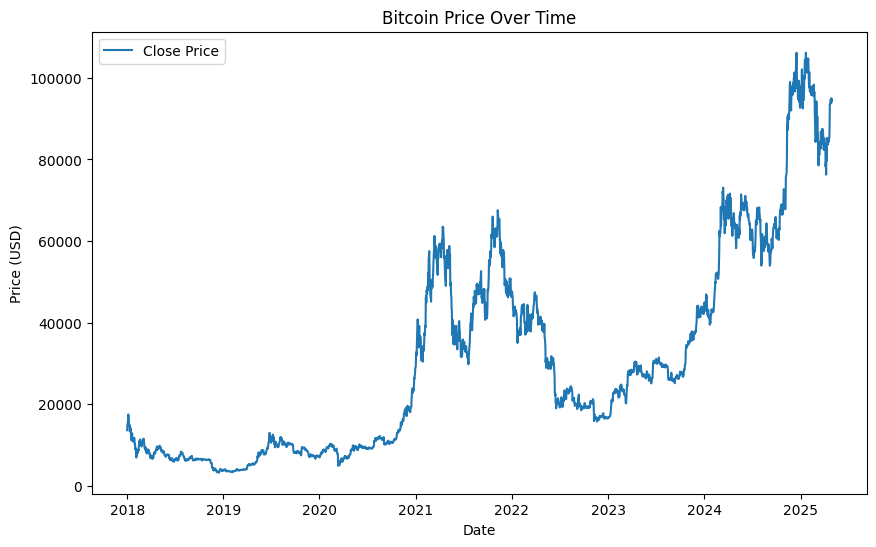

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## 4. Kiểm tra tính dừng (stationarity) và thực hiện sai phân (nếu có)
### 4.1. Kiểm định ADF để kiểm tra tính dừng

In [8]:
from statsmodels.tsa.stattools import adfuller

# Kiểm định ADF trên chuỗi gốc
result = adfuller(df['Close'])
print('ADF Statistic (Gốc):', result[0])
print('p-value (Gốc):', result[1])

print('==> Chuỗi gốc là chuỗi không dừng (Non-Stationary) vì p-value > 0.05' if result[1] > 0.05 else 'Chuỗi gốc là chuỗi dừng')

ADF Statistic (Gốc): -0.3554177424709135
p-value (Gốc): 0.9172805422803809
==> Chuỗi gốc là chuỗi không dừng (Non-Stationary) vì p-value > 0.05


### 4.2. Lấy sai phân bậc 1

In [9]:
df['Close_Diff'] = df['Close'].diff().dropna()

### 4.3. Thực hiện kiểm định ADF trên chuỗi đã sai phân

In [10]:
result_diff = adfuller(df['Close_Diff'].dropna())
print('ADF Statistic (Đã sai phân):', result_diff[0])
print('p-value (Đã sai phân):', result_diff[1])

print('Kết luận: Chuỗi đã sai phân là dừng (Stationary) vì p-value < 0.05' if result_diff[1] < 0.05 else 'Chuỗi vẫn không dừng')

ADF Statistic (Đã sai phân): -8.48206944150192
p-value (Đã sai phân): 1.384519600134983e-13
Kết luận: Chuỗi đã sai phân là dừng (Stationary) vì p-value < 0.05


## 5. Vẽ biểu đồ giá "Close" sau khi đã sai phân để xác nhận tính dừng

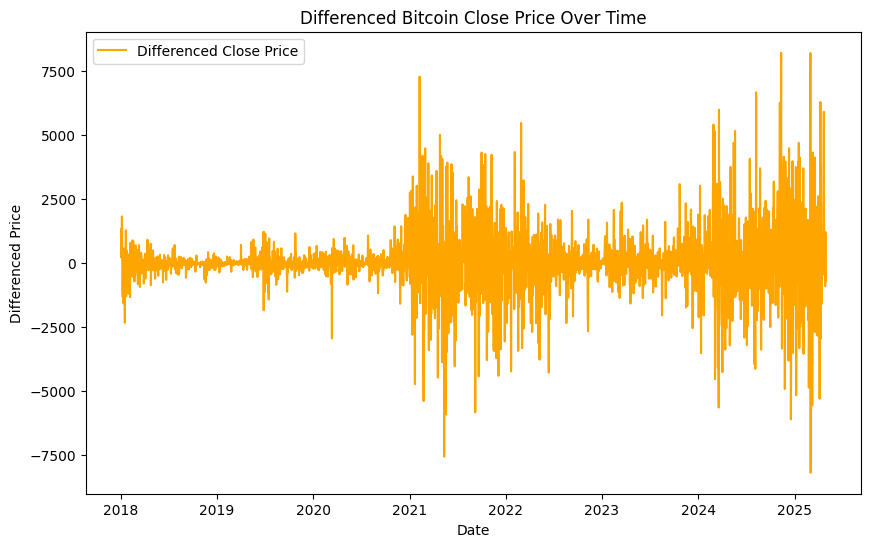

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close_Diff'], color='orange', label='Differenced Close Price')
plt.title('Differenced Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

## 6. Vẽ ACF và PACF để xác định các (p, d, q) của mô hình ARIMA

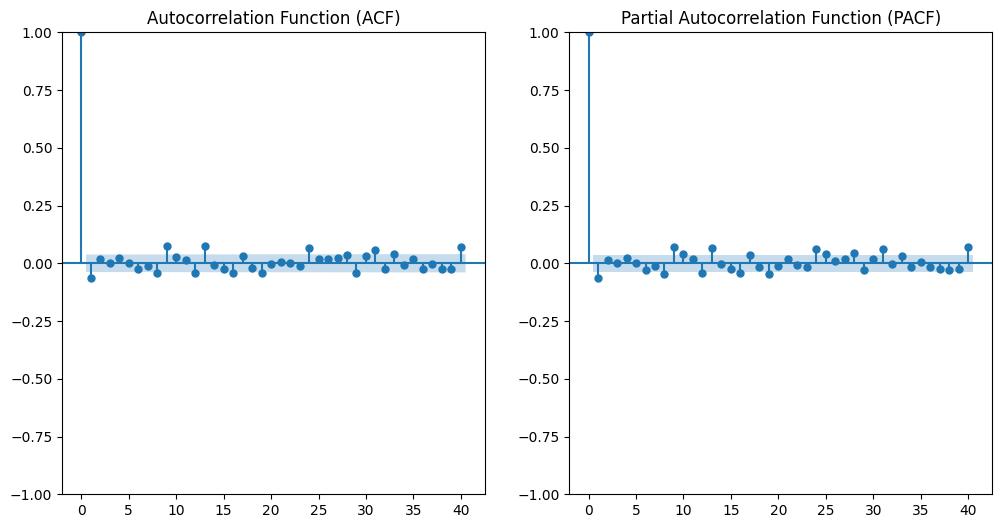

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Close_Diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(df['Close_Diff'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### Nhận xét
- Vì đã sai phân rồi → chọn d = 1
- ACF:
  - Rớt mạnh sau lag 1 và dao động quanh 0 → dấu hiệu cho thấy q = 0 hoặc 1
- PACF:
  - Rớt mạnh sau lag 1, các lag sau không đáng kể → p = 0 hoặc 1
- Vì cả hai biểu đồ đều giảm mạnh sau lag 1 và không có đỉnh nổi bật sau đó → có vẻ dữ liệu đã khá trắng sau sai phân

### Đề xuất 3 mô hình. Từ đó, dùng các chỉ số AIC, BIC, RMSE để đánh giá hiệu suất mô hình và chọn ra mô hình tốt nhất để thực hiện dự báo
Mô hình 1: ARIMA(1, 1, 0)

Mô hình 2: ARIMA(0, 1, 1)

Mô hình 3: ARIMA(1, 1, 1)

## 7. Chia tập train và tập test theo tỷ lệ 8:2

In [13]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

## 8. Huấn luyện mô hình ARIMA

### 8.1 Mô hình 1: ARIMA(1, 1, 0)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_model1 = ARIMA(train, order=(1,1,0))
arima_model_fit_1 = arima_model1.fit()

# In tóm tắt mô hình
print(arima_model_fit_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17719.048
Date:                Fri, 13 Jun 2025   AIC                          35442.096
Time:                        10:24:14   BIC                          35453.433
Sample:                    01-01-2018   HQIC                         35446.245
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.014     -1.609      0.108      -0.049       0.005
sigma2      9.172e+05   1.13e+04     81.400      0.000    8.95e+05    9.39e+05
Ljung-Box (L1) (Q):                   0.05   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### 8.2 Mô hình 2: ARIMA(0, 1, 1)

In [15]:
arima_model2 = ARIMA(train, order=(0,1,1))
arima_model_fit_2 = arima_model2.fit()

# In tóm tắt mô hình
print(arima_model_fit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -17719.062
Date:                Fri, 13 Jun 2025   AIC                          35442.124
Time:                        10:25:22   BIC                          35453.460
Sample:                    01-01-2018   HQIC                         35446.272
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0213      0.014     -1.567      0.117      -0.048       0.005
sigma2      9.168e+05   1.13e+04     81.458      0.000    8.95e+05    9.39e+05
Ljung-Box (L1) (Q):                   0.06   Jarque-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### 8.3 Mô hình 1: ARIMA(1, 1, 1)

In [16]:
arima_model3 = ARIMA(train, order=(1,1,1))
arima_model_fit_3 = arima_model3.fit()

# In tóm tắt mô hình
print(arima_model_fit_3.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17718.982
Date:                Fri, 13 Jun 2025   AIC                          35443.963
Time:                        10:25:29   BIC                          35460.967
Sample:                    01-01-2018   HQIC                         35450.185
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2835      0.544     -0.521      0.602      -1.350       0.783
ma.L1          0.2613      0.549      0.476      0.634      -0.814       1.337
sigma2      9.168e+05   1.13e+04     80.868      0.0

## 9. Đánh giá dự báo trên tập test và trực quan kết quả của 3 mô hình

### 9.1 Dự báo trên tập test

In [17]:
arima_forecast1 = arima_model_fit_1.forecast(steps=len(test))
arima_forecast2 = arima_model_fit_2.forecast(steps=len(test))
arima_forecast3 = arima_model_fit_3.forecast(steps=len(test))

### 9.2 Trực quan hoá kết quả dự báo của 3 mô hình

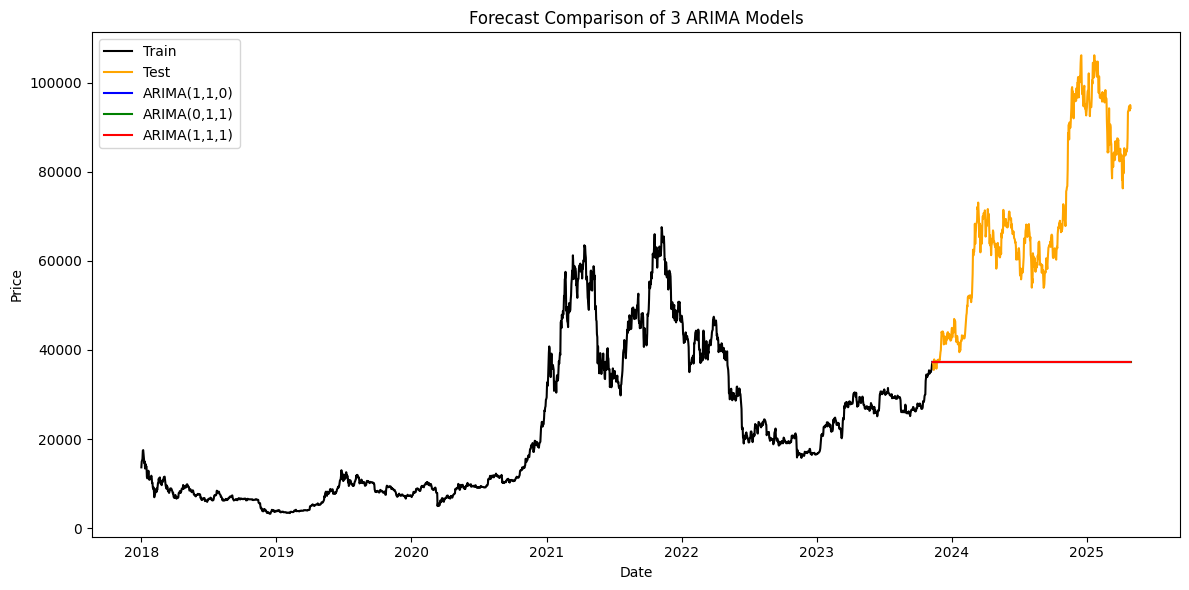

In [18]:
plt.figure(figsize=(12,6))

# Vẽ dữ liệu thực tế
plt.plot(train.index, train, label='Train', color='black')
plt.plot(test.index, test, label='Test', color='orange')

# Vẽ dự báo của 3 mô hình với màu khác nhau
plt.plot(test.index, arima_forecast1, label='ARIMA(1,1,0)', color='blue')
plt.plot(test.index, arima_forecast2, label='ARIMA(0,1,1)', color='green')
plt.plot(test.index, arima_forecast3, label='ARIMA(1,1,1)', color='red')

# Thêm tiêu đề, nhãn và chú thích
plt.title('Forecast Comparison of 3 ARIMA Models')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Không hiển thị lưới
plt.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

## 10. Đánh giá hiệu suất của 3 mô hình bằng các chỉ số AIC, BIC, RMSE, MAE, MAPE, R²

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSE
arima_rmse1 = np.sqrt(mean_squared_error(test, arima_forecast1))
arima_rmse2 = np.sqrt(mean_squared_error(test, arima_forecast2))
arima_rmse3 = np.sqrt(mean_squared_error(test, arima_forecast3))

# MAE
arima_mae1 = mean_absolute_error(test, arima_forecast1)
arima_mae2 = mean_absolute_error(test, arima_forecast2)
arima_mae3 = mean_absolute_error(test, arima_forecast3)

# MAPE - tránh chia cho 0
arima_mape1 = np.mean(np.abs((test - arima_forecast1) / test)) * 100
arima_mape2 = np.mean(np.abs((test - arima_forecast2) / test)) * 100
arima_mape3 = np.mean(np.abs((test - arima_forecast3) / test)) * 100

# R²
arima_r2_1 = r2_score(test, arima_forecast1)
arima_r2_2 = r2_score(test, arima_forecast2)
arima_r2_3 = r2_score(test, arima_forecast3)

evaluation = pd.DataFrame({
    'Model': ['ARIMA(1,1,0)', 'ARIMA(0,1,1)', 'ARIMA(1,1,1)'],
    'AIC': [arima_model_fit_1.aic, arima_model_fit_2.aic, arima_model_fit_3.aic],
    'BIC': [arima_model_fit_1.bic, arima_model_fit_2.bic, arima_model_fit_3.bic],
    'RMSE': [arima_rmse1, arima_rmse2, arima_rmse3],
    'MAE': [arima_mae1, arima_mae2, arima_mae3],
    'MAPE (%)': [arima_mape1, arima_mape2, arima_mape3],
    'R²': [arima_r2_1, arima_r2_2, arima_r2_3]
})

print(evaluation)

          Model           AIC           BIC          RMSE           MAE  \
0  ARIMA(1,1,0)  35442.096336  35453.432523  37119.364383  31958.607863   
1  ARIMA(0,1,1)  35442.123915  35453.460102  37119.723344  31959.010091   
2  ARIMA(1,1,1)  35443.963081  35460.967362  37113.260644  31951.775192   

    MAPE (%)        R²  
0  41.687042 -2.846776  
1  41.687654 -2.846851  
2  41.676654 -2.845511  


### Kết luận

| Tiêu chí | Mục tiêu            | Mô hình tốt nhất                              |
| -------- | ------------------- | --------------------------------------------- |
| **AIC**  | Càng thấp càng tốt  | **ARIMA(1,1,0)** (AIC = 35442.10)             |
| **BIC**  | Càng thấp càng tốt  | **ARIMA(1,1,0)**                              |
| **RMSE** | Càng thấp càng tốt  | **ARIMA(1,1,1)** *(thấp nhất: 37113.26)*      |
| **MAE**  | Càng thấp càng tốt  | **ARIMA(1,1,1)** *(thấp nhất: 31951.78)*      |
| **MAPE** | Càng thấp càng tốt  | **ARIMA(1,1,1)** *(thấp nhất: 41.68%)*        |
| **R²**   | Càng gần 1 càng tốt | **Không có mô hình nào tốt** – tất cả đều < 0 |

📌 Giải thích thêm về R² âm
- R² < 0 nghĩa là mô hình kém hơn trung bình cộng của dữ liệu.
- R² âm có thể xảy ra khi:
  - Dữ liệu rất biến động, nhiều nhiễu (rất thường gặp trong dữ liệu tài chính như Bitcoin).
  - Mô hình quá đơn giản, chưa nắm bắt được xu hướng.
  - Không có đặc trưng (feature) nào khác ngoài giá trước đó.

📌 Lưu ý: ARIMA là mô hình tuyến tính, trong khi giá Bitcoin có thể phi tuyến và chứa nhiều biến ẩn → có thể thử thêm SARIMA hoặc LSTM.


✅ Dựa trên các độ đo:
- Nếu ưu tiên AIC/BIC → ARIMA(1,1,0)
- **Nếu ưu tiên RMSE/MAE/MAPE → ARIMA(1,1,1)**
- Nhưng cả ba mô hình đều có R² rất kém, cần cân nhắc cải tiến mô hình.


## 11. Dùng mô hình ARIMA (1,1,1) để dự báo giá bitcoin của 30 ngày tiếp theo trong tương lai

### 11.1 Biểu đồ dự báo trên tập test của ARIMA (1,1,1)

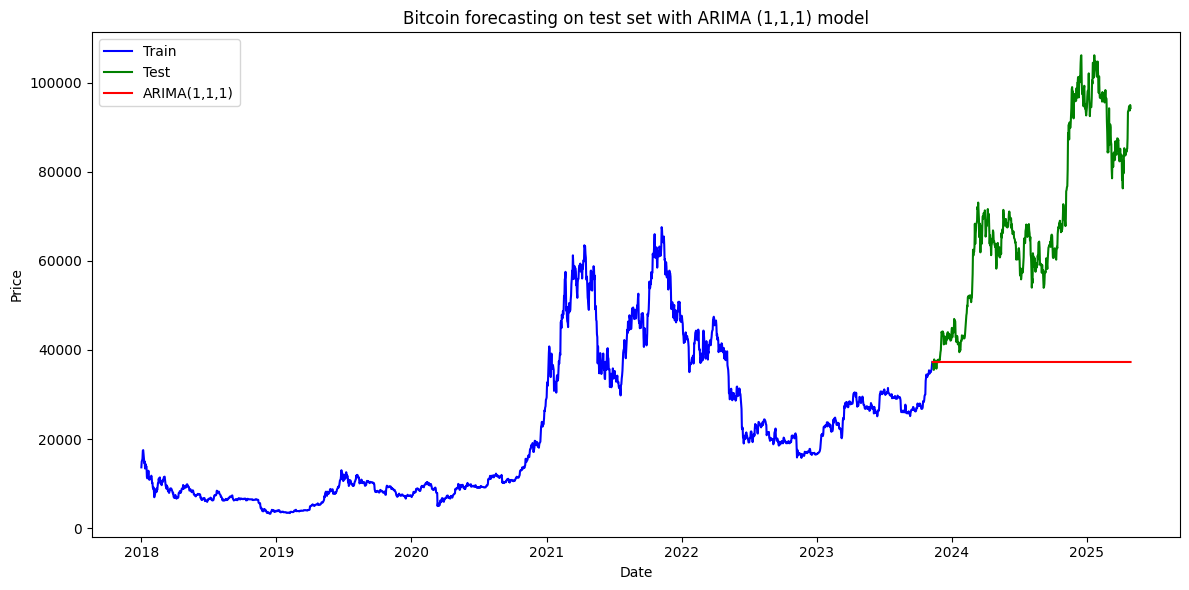

In [21]:
plt.figure(figsize=(12,6))

# Vẽ dữ liệu thực tế
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')

plt.plot(test.index, arima_forecast3, label='ARIMA(1,1,1)', color='red')

# Thêm tiêu đề, nhãn và chú thích
plt.title('Bitcoin forecasting on test set with ARIMA (1,1,1) model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Không hiển thị lưới
plt.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### 11.2 Dùng toàn bộ dữ liệu để retrain mô hình & Dự báo 30 ngày tiếp theo

In [22]:
# Dùng toàn bộ dữ liệu để retrain mô hình
arima_full_model = ARIMA(df['Close'], order=(1, 1, 1))
arima_full_fit = arima_full_model.fit()

# Dự báo 30 ngày tiếp theo
arima_future_forecast = arima_full_fit.forecast(steps=30)
print(arima_future_forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2025-04-30    94346.972458
2025-05-01    94326.722656
2025-05-02    94333.316932
2025-05-03    94331.169529
2025-05-04    94331.868823
2025-05-05    94331.641101
2025-05-06    94331.715258
2025-05-07    94331.691109
2025-05-08    94331.698973
2025-05-09    94331.696412
2025-05-10    94331.697246
2025-05-11    94331.696974
2025-05-12    94331.697063
2025-05-13    94331.697034
2025-05-14    94331.697043
2025-05-15    94331.697040
2025-05-16    94331.697041
2025-05-17    94331.697041
2025-05-18    94331.697041
2025-05-19    94331.697041
2025-05-20    94331.697041
2025-05-21    94331.697041
2025-05-22    94331.697041
2025-05-23    94331.697041
2025-05-24    94331.697041
2025-05-25    94331.697041
2025-05-26    94331.697041
2025-05-27    94331.697041
2025-05-28    94331.697041
2025-05-29    94331.697041
Freq: D, Name: predicted_mean, dtype: float64


### 11.3 Gán ngày cho các giá trị dự báo

In [23]:
# Lấy ngày cuối cùng trong tập dữ liệu
# Nếu Date là index
if 'Date' not in df.columns:
    last_date = df.index[-1]
else:
    df.columns = df.columns.str.strip()  # Xóa khoảng trắng nếu có
    last_date = pd.to_datetime(df['Date'].iloc[-1])

# Tạo 30 ngày tiếp theo
arima_future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Kết hợp ngày với dự báo
arima_forecast_df = pd.DataFrame({
    'Date': arima_future_dates,
    'Forecasted Close': arima_future_forecast
})

print(arima_forecast_df)

                 Date  Forecasted Close
2025-04-30 2025-04-30      94346.972458
2025-05-01 2025-05-01      94326.722656
2025-05-02 2025-05-02      94333.316932
2025-05-03 2025-05-03      94331.169529
2025-05-04 2025-05-04      94331.868823
2025-05-05 2025-05-05      94331.641101
2025-05-06 2025-05-06      94331.715258
2025-05-07 2025-05-07      94331.691109
2025-05-08 2025-05-08      94331.698973
2025-05-09 2025-05-09      94331.696412
2025-05-10 2025-05-10      94331.697246
2025-05-11 2025-05-11      94331.696974
2025-05-12 2025-05-12      94331.697063
2025-05-13 2025-05-13      94331.697034
2025-05-14 2025-05-14      94331.697043
2025-05-15 2025-05-15      94331.697040
2025-05-16 2025-05-16      94331.697041
2025-05-17 2025-05-17      94331.697041
2025-05-18 2025-05-18      94331.697041
2025-05-19 2025-05-19      94331.697041
2025-05-20 2025-05-20      94331.697041
2025-05-21 2025-05-21      94331.697041
2025-05-22 2025-05-22      94331.697041
2025-05-23 2025-05-23      94331.697041


### 11.4 Vẽ biểu đồ kết quả (thực tế + dự báo tương lai)

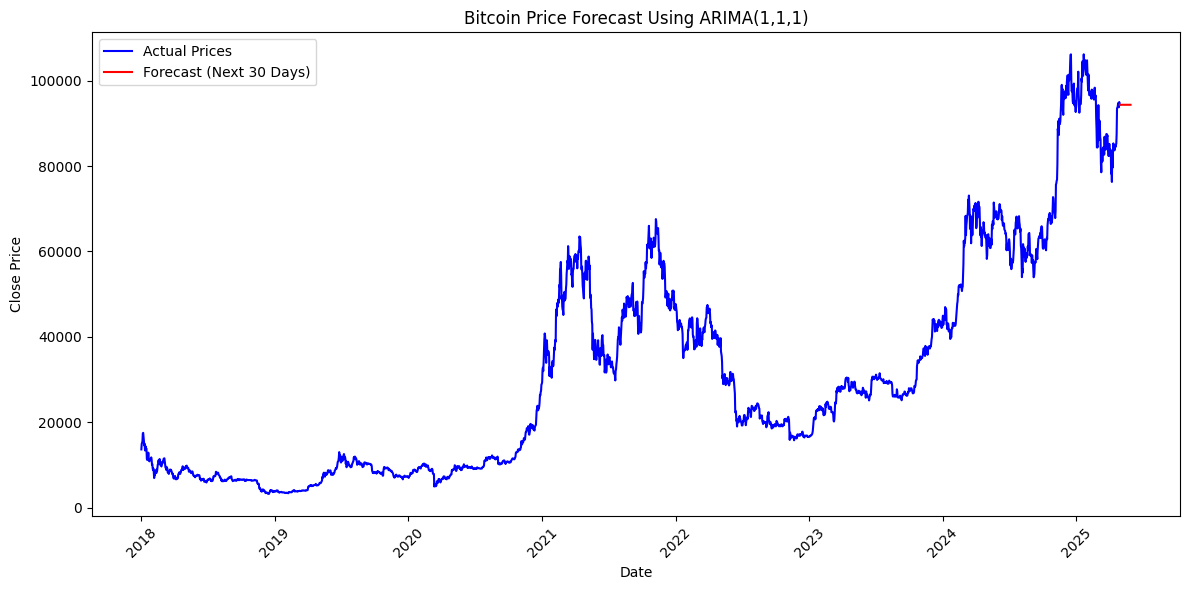

In [24]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Actual Prices', color='blue')
plt.plot(arima_forecast_df['Date'], arima_forecast_df['Forecasted Close'], label='Forecast (Next 30 Days)', color='red')
plt.title('Bitcoin Price Forecast Using ARIMA(1,1,1)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Dự đoán giá bitcoin sử dụng mô hình ARIMAX
*Biến ngoại sinh (Exogenous Variable) là Khối lượng giao dịch (Volume)*

## 1. Kiểm tra tương quan giữa Volume và Giá Close

In [25]:
df[['Close', 'Volume']].corr()

,Close,Volume
Close,1.000000,0.494287
Volume,0.494287,1.000000


- Hệ số tương quan giữa Close (giá đóng cửa) và Volume (khối lượng giao dịch) là 0.4943. Đây là mức tương quan trung bình, không quá yếu, nhưng cũng không quá mạnh.
#### Kết luận:
  - Volume có ảnh hưởng nhất định đến giá → có thể cân nhắc sử dụng mô hình ARIMAX để đưa Volume làm biến ngoại sinh (exogenous variable).
  - Cần so sánh AIC, BIC, RMSE, MAE, MAPE, R² giữa ARIMA và ARIMAX.

## 2. Chia tập train và tập test

In [26]:
train_size = int(len(df) * 0.8)

y_train = df['Close'][:train_size]
y_test = df['Close'][train_size:]

exog_train = df['Volume'][:train_size]
exog_test = df['Volume'][train_size:]

## 3. Cũng giống ARIMA, dựa vào biểu đồ ACF và PACF, đề xuất được 3 mô hình để thử nghiệm trên mô hình ARIMAX
### Lưu ý:
**Mặc dù mô hình "ARIMAX" là khái niệm lý thuyết (ARIMA có biến ngoại sinh), trong thư viện statsmodels thì phải dùng class SARIMAX để cài đặt ARIMAX (chỉ định exog=... nhưng KHÔNG cần khai báo phần mùa vụ (seasonal_order))**
- SARIMAX trong statsmodels là mô hình tổng quát, bao gồm:
  - ARIMA
  - ARIMAX (ARIMA with exog)
  - Seasonal ARIMA (SARIMA)
  - Seasonal ARIMAX (SARIMAX)

### 3.1 Mô hình 1: ARIMAX(1,1,0)

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax_model1 = SARIMAX(y_train, order=(1,1,0), exog=exog_train)
arimax_model_fit_1 = arimax_model1.fit()

# In tóm tắt mô hình
print(arimax_model_fit_1.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -17716.133
Date:                Fri, 13 Jun 2025   AIC                          35438.266
Time:                        10:41:44   BIC                          35455.270
Sample:                    01-01-2018   HQIC                         35444.489
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -4.146e-09   1.04e-09     -3.970      0.000   -6.19e-09    -2.1e-09
ar.L1         -0.0260      0.014     -1.887      0.059      -0.053       0.001
sigma2      9.146e+05   5.89e-10   1.55e+15      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 3.2 Mô hình 2: ARIMAX(0,1,1)

In [28]:
arimax_model2 = SARIMAX(y_train, order=(0,1,1), exog=exog_train)
arimax_model_fit_2 = arimax_model2.fit()

# In tóm tắt mô hình
print(arimax_model_fit_2.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -17716.156
Date:                Fri, 13 Jun 2025   AIC                          35438.311
Time:                        10:41:58   BIC                          35455.316
Sample:                    01-01-2018   HQIC                         35444.534
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -4.146e-09   1.04e-09     -3.974      0.000   -6.19e-09    -2.1e-09
ma.L1         -0.0263      0.014     -1.902      0.057      -0.053       0.001
sigma2      9.142e+05   4.34e-10    2.1e+15      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 3.3 Mô hình 3: ARIMAX(1,1,1)

In [29]:
arimax_model3 = SARIMAX(y_train, order=(1,1,1), exog=exog_train)
arimax_model_fit_3 = arimax_model3.fit()

# In tóm tắt mô hình
print(arimax_model_fit_3.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2140
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -17716.136
Date:                Fri, 13 Jun 2025   AIC                          35440.272
Time:                        10:42:09   BIC                          35462.944
Sample:                    01-01-2018   HQIC                         35448.568
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -4.146e-09   1.04e-09     -3.972      0.000   -6.19e-09    -2.1e-09
ar.L1         -0.0263      0.007     -3.811      0.000      -0.040      -0.013
ma.L1       4.628e-05      0.007      0.007      0.9

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4. Đánh giá dự báo trên tập test và trực quan kết quả của 3 mô hình

### 4.1 Dự báo trên tập test và exog_test

In [30]:
arimax_forecast1 = arimax_model_fit_1.forecast(steps=len(y_test), exog=exog_test)
arimax_forecast2 = arimax_model_fit_2.forecast(steps=len(y_test), exog=exog_test)
arimax_forecast3 = arimax_model_fit_3.forecast(steps=len(y_test), exog=exog_test)

### 4.2 Trực quan hoá kết quả dự báo của 3 mô hình

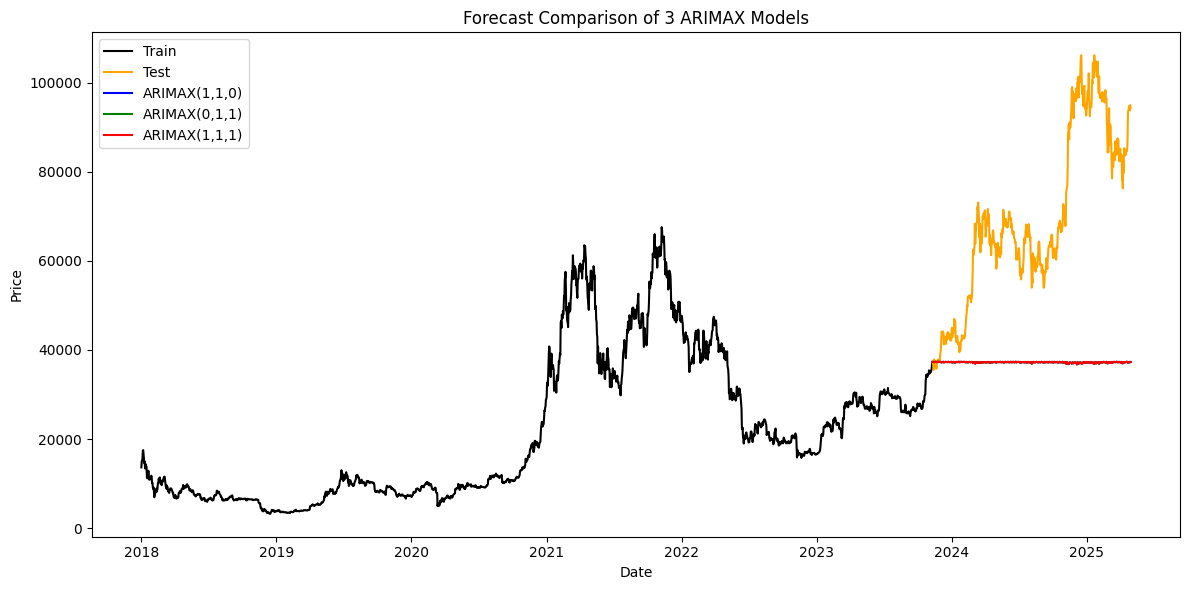

In [31]:
plt.figure(figsize=(12,6))

# Vẽ dữ liệu thực tế
plt.plot(train.index, train, label='Train', color='black')
plt.plot(test.index, test, label='Test', color='orange')

# Vẽ dự báo của 3 mô hình với màu khác nhau
plt.plot(test.index, arimax_forecast1, label='ARIMAX(1,1,0)', color='blue')
plt.plot(test.index, arimax_forecast2, label='ARIMAX(0,1,1)', color='green')
plt.plot(test.index, arimax_forecast3, label='ARIMAX(1,1,1)', color='red')

# Thêm tiêu đề, nhãn và chú thích
plt.title('Forecast Comparison of 3 ARIMAX Models')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Không hiển thị lưới
plt.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

## 5. Đánh giá hiệu suất của 3 mô hình bằng các chỉ số AIC, BIC, RMSE, MAE, MAPE, R²

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSE
arimax_rmse1 = np.sqrt(mean_squared_error(y_test, arimax_forecast1))
arimax_rmse2 = np.sqrt(mean_squared_error(y_test, arimax_forecast2))
arimax_rmse3 = np.sqrt(mean_squared_error(y_test, arimax_forecast3))

# MAE
arimax_mae1 = mean_absolute_error(y_test, arimax_forecast1)
arimax_mae2 = mean_absolute_error(y_test, arimax_forecast2)
arimax_mae3 = mean_absolute_error(y_test, arimax_forecast3)

# MAPE
arimax_mape1 = np.mean(np.abs((y_test - arimax_forecast1) / y_test)) *100
arimax_mape2 = np.mean(np.abs((y_test - arimax_forecast2) / y_test)) *100
arimax_mape3 = np.mean(np.abs((y_test - arimax_forecast3) / y_test)) *100

# R²
arimax_r2_1 = r2_score(y_test, arimax_forecast1)
arimax_r2_2 = r2_score(y_test, arimax_forecast2)
arimax_r2_3 = r2_score(y_test, arimax_forecast3)

arimax_evaluation = pd.DataFrame({
    'Model': ['ARIMAX(1,1,0)', 'ARIMAX(0,1,1)', 'ARIMAX(1,1,1)'],
    'AIC': [arimax_model_fit_1.aic, arimax_model_fit_2.aic, arimax_model_fit_3.aic],
    'BIC': [arimax_model_fit_1.bic, arimax_model_fit_2.bic, arimax_model_fit_3.bic],
    'RMSE': [arimax_rmse1, arimax_rmse2, arimax_rmse3],
    'MAE': [arimax_mae1, arimax_mae2, arimax_mae3],
    'MAPE (%)': [arimax_mape1, arimax_mape2, arimax_mape3],
    'R²': [arimax_r2_1, arimax_r2_2, arimax_r2_3]
})

print(arimax_evaluation)

           Model           AIC           BIC          RMSE           MAE  \
0  ARIMAX(1,1,0)  35438.266133  35455.270414  37194.015014  32019.160940   
1  ARIMAX(0,1,1)  35438.311418  35455.315699  37195.108246  32020.385164   
2  ARIMAX(1,1,1)  35440.271858  35462.944233  37194.115101  32019.272947   

    MAPE (%)        R²  
0  41.763372 -2.862264  
1  41.765234 -2.862491  
2  41.763543 -2.862285  


### Kết luận

| Tiêu chí | Mô hình tốt nhất                | Ghi chú                            |
| -------- | ------------------------------- | ---------------------------------- |
| **AIC**  | ✅ ARIMAX(1,1,0)                 | Thấp nhất ⇒ Ưu tiên                |
| **BIC**  | ✅ ARIMAX(1,1,0)                 | Thấp nhất                          |
| **RMSE** | ✅ ARIMAX(1,1,1)                 | Nhỏ nhất, nhưng chênh lệch rất nhỏ |
| **MAE**  | ✅ ARIMAX(1,1,1)                 | Nhỏ nhất                           |
| **MAPE** | ✅ ARIMAX(1,1,0)                 | Nhỏ nhất                           |
| **R²**   | ✅ ARIMAX(1,1,0) ≈ ARIMAX(1,1,1) | Gần tương đương                    |


**→ Chọn mô hình: ARIMAX(1,1,0)**. Bởi vì:
- Nó có AIC và BIC thấp nhất, giúp tránh overfitting.
- Các độ đo dự báo (RMSE, MAE, MAPE, R²) gần như không khác biệt đáng kể so với các mô hình khác.
- Là mô hình đơn giản hơn so với ARIMAX(1,1,1) nên dễ giải thích và tiết kiệm tài nguyên.

## 6. Dùng mô hình ARIMAX (1,1,0) để dự báo giá bitcoin của 30 ngày tiếp theo trong tương lai

### 6.1 Biểu đồ dự báo trên tập test của ARIMAX (1,1,0)

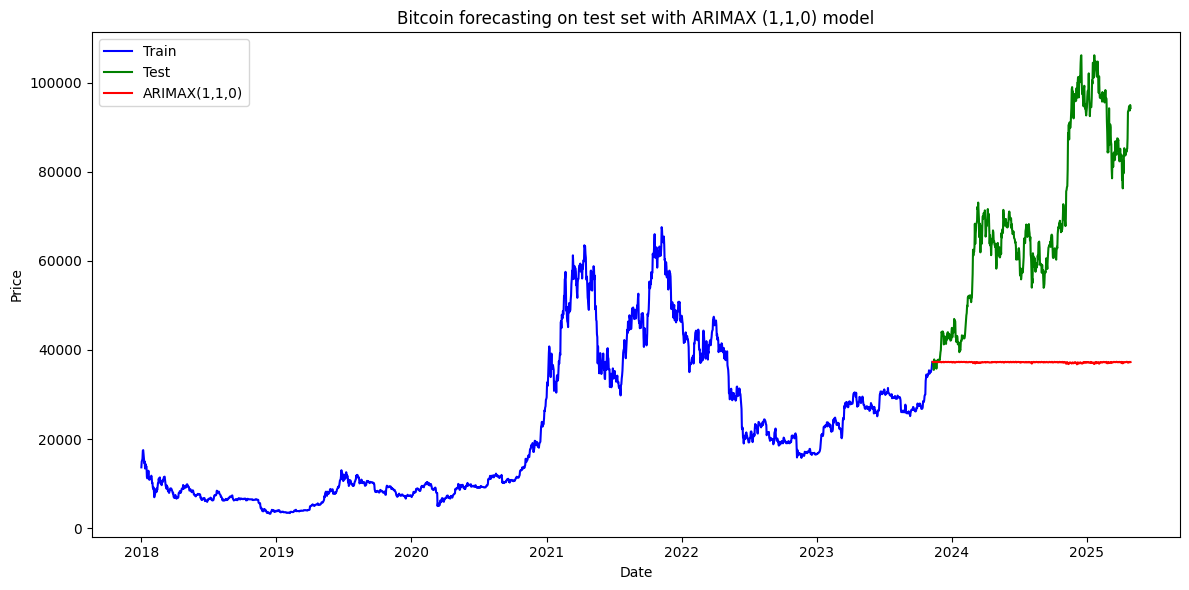

In [33]:
plt.figure(figsize=(12,6))

# Vẽ dữ liệu thực tế
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')

plt.plot(test.index, arimax_forecast1, label='ARIMAX(1,1,0)', color='red')

# Thêm tiêu đề, nhãn và chú thích
plt.title('Bitcoin forecasting on test set with ARIMAX (1,1,0) model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Không hiển thị lưới
plt.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

### 6.2 Dùng toàn bộ dữ liệu để retrain mô hình & Dự báo 30 ngày tiếp theo

In [34]:
# Fit full ARIMAX model
arimax_full_model = SARIMAX(df['Close'], order=(1, 1, 0), exog=df['Volume'])
arimax_full_fit = arimax_full_model.fit()

# Giả sử dự báo 30 ngày tiếp theo, cần chuẩn bị volume cho tương lai
# Nếu chưa có volume tương lai, có thể dùng giá trị trung bình/gần nhất hoặc dự báo volume riêng
arimax_last_volume = df['Volume'].iloc[-1]
arimax_future_exog = np.full(30, arimax_last_volume)  # giả sử giữ nguyên volume

# Dự báo 30 ngày tiếp theo
arimax_future_forecast = arimax_full_fit.forecast(steps=30, exog=arimax_future_exog)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 6.3 Gán ngày cho các giá trị dự báo

In [35]:
# Lấy ngày cuối cùng trong tập dữ liệu
# Nếu Date là index
if 'Date' not in df.columns:
    arimax_last_date = df.index[-1]
else:
    df.columns = df.columns.str.strip()  # Xóa khoảng trắng nếu có
    arimax_last_date = pd.to_datetime(df['Date'].iloc[-1])

# Tạo 30 ngày tiếp theo
arimax_future_dates = pd.date_range(start=arimax_last_date + pd.Timedelta(days=1), periods=30)

# Kết hợp ngày với dự báo
arimax_forecast_df = pd.DataFrame({
    'Date': arimax_future_dates,
    'Forecasted Close': arimax_future_forecast
})

print(arimax_forecast_df)

                 Date  Forecasted Close
2025-04-30 2025-04-30      94329.301312
2025-05-01 2025-05-01      94326.497672
2025-05-02 2025-05-02      94326.674261
2025-05-03 2025-05-03      94326.663139
2025-05-04 2025-05-04      94326.663839
2025-05-05 2025-05-05      94326.663795
2025-05-06 2025-05-06      94326.663798
2025-05-07 2025-05-07      94326.663798
2025-05-08 2025-05-08      94326.663798
2025-05-09 2025-05-09      94326.663798
2025-05-10 2025-05-10      94326.663798
2025-05-11 2025-05-11      94326.663798
2025-05-12 2025-05-12      94326.663798
2025-05-13 2025-05-13      94326.663798
2025-05-14 2025-05-14      94326.663798
2025-05-15 2025-05-15      94326.663798
2025-05-16 2025-05-16      94326.663798
2025-05-17 2025-05-17      94326.663798
2025-05-18 2025-05-18      94326.663798
2025-05-19 2025-05-19      94326.663798
2025-05-20 2025-05-20      94326.663798
2025-05-21 2025-05-21      94326.663798
2025-05-22 2025-05-22      94326.663798
2025-05-23 2025-05-23      94326.663798


### 6.4 Vẽ biểu đồ kết quả (thực tế + dự báo tương lai)

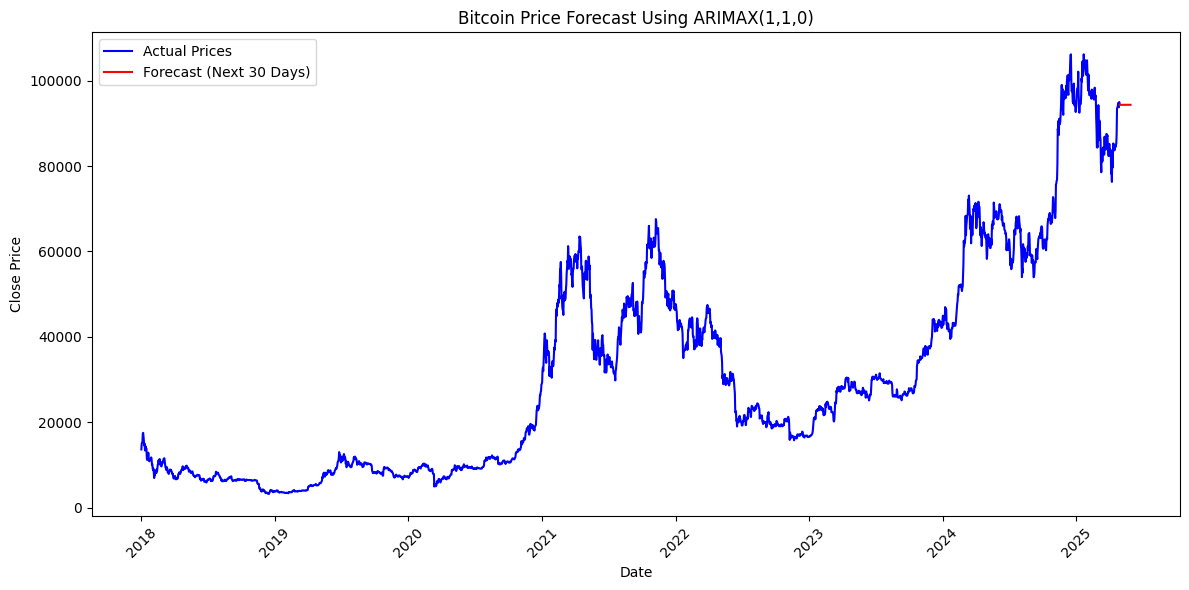

In [36]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Actual Prices', color='blue')
plt.plot(arimax_forecast_df['Date'], arimax_forecast_df['Forecasted Close'], label='Forecast (Next 30 Days)', color='red')
plt.title('Bitcoin Price Forecast Using ARIMAX(1,1,0)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# So sánh giữa ARIMA (1,1,1) và ARIMAX (1,1,0) được chọn

In [37]:
full_comparison = pd.concat([evaluation, arimax_evaluation], axis=0)

In [38]:
print(full_comparison)

           Model           AIC           BIC          RMSE           MAE  \
0   ARIMA(1,1,0)  35442.096336  35453.432523  37119.364383  31958.607863   
1   ARIMA(0,1,1)  35442.123915  35453.460102  37119.723344  31959.010091   
2   ARIMA(1,1,1)  35443.963081  35460.967362  37113.260644  31951.775192   
0  ARIMAX(1,1,0)  35438.266133  35455.270414  37194.015014  32019.160940   
1  ARIMAX(0,1,1)  35438.311418  35455.315699  37195.108246  32020.385164   
2  ARIMAX(1,1,1)  35440.271858  35462.944233  37194.115101  32019.272947   

    MAPE (%)        R²  
0  41.687042 -2.846776  
1  41.687654 -2.846851  
2  41.676654 -2.845511  
0  41.763372 -2.862264  
1  41.765234 -2.862491  
2  41.763543 -2.862285  


📊 So sánh ARIMA(1,1,1) và ARIMAX(1,1,0)

| Độ đo        | **ARIMA(1,1,1)**   | **ARIMAX(1,1,0)**  |
| ------------ | ------------------ | ------------------ |
| **AIC**      | 35443.963081       | **35438.266133** ✅ |
| **BIC**      | 35460.967362       | 35455.270414       |
| **RMSE**     | **37113.260644** ✅ | 37194.015014       |
| **MAE**      | **31951.775192** ✅ | 32019.160940       |
| **MAPE (%)** | **41.676654** ✅    | 41.763372          |
| **R²**       | **-2.845511** ✅    | -2.862264          |


## Đánh giá trực quan từ biểu đồ dự báo giá trên tập test của hai mô hình
- ARIMA (1,1,1):
  - Đường dự báo (màu đỏ) nằm ngang, có vẻ bám sát giá đầu tiên của tập test.
  - Tuy nhiên, không phản ánh xu hướng tăng rõ rệt trong tập test, thể hiện mô hình bị “trơ” với sự biến động thị trường.
- ARIMAX (1,1,0):
  - Dự báo dao động nhẹ quanh một giá trị trung bình.
  - Tuy cũng không theo sát xu hướng tăng, nhưng có phản ứng biến động nhẹ hơn, có thể do tác động từ biến ngoại sinh.

## Kết luận
- Nếu đánh giá dựa trên RMSE, MAE, MAPE, và R² → ARIMA(1,1,1) tốt hơn vì dự báo gần giá trị thực hơn.
- Nếu đánh giá dựa trên AIC (Akaike Information Criterion) → ARIMAX(1,1,0) tốt hơn vì mô hình có tính tổng quát hóa tốt hơn (phù hợp hơn với dữ liệu tổng thể), mô hình đơn giản hơn về mặt thống kê và có thể tránh overfitting.
- Về mặt trực quan: Cả hai mô hình đều chưa theo kịp xu hướng tăng đột biến của giá Bitcoin trong tập test. Điều này cho thấy cả hai mô hình đều mang tính bảo thủ, có thể vì đặc điểm của ARIMA/ARIMAX vốn không dự đoán tốt các xu hướng mang tính phi tuyến và đột ngột.